<a href="https://colab.research.google.com/github/j4breu/Git-Workspace/blob/main/tetris_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install pygame

In [140]:
!pip install pygame

##Dependencies

In [141]:
import cv2
from os import environ

from google.colab.patches import cv2_imshow
from google.colab import output

##Fool system to think it has a video access

In [142]:
# set SDL to use the dummy NULL video driver,
#   so it doesn't need a windowing system.
environ["SDL_VIDEODRIVER"] = "dummy"

##Settings

In [143]:
import pygame

# Game size
COLUMNS = 10
ROWS = 20
CELL_SIZE = 40
GAME_WIDTH, GAME_HEIGHT = COLUMNS * CELL_SIZE, ROWS * CELL_SIZE

# window
PADDING = 20
WINDOW_WIDTH = GAME_WIDTH + PADDING * 2
WINDOW_HEIGHT = GAME_HEIGHT + PADDING * 2

# game behaviour
UPDATE_START_SPEED = 50
MOVE_WAIT_TIME = 50
ROTATE_WAIT_TIME = 50
BLOCK_OFFSET = pygame.Vector2(COLUMNS // 2 - 1, 2)

# Colors
YELLOW = '#f1e60d'
RED = '#e51b20'
BLUE = '#204b9b'
GREEN = '#65b32e'
PURPLE = '#7b217f'
CYAN = '#6cc6d9'
ORANGE = '#f07e13'
GRAY = '#1C1C1C'
LINE_COLOR = '#FFFFFF'

# shapes
TETROMINOS = {
	'T': {'shape': [(0,0), (-1,0), (1,0), (0,-1)], 'color': PURPLE},
	'O': {'shape': [(0,0), (0,-1), (1,0), (1,-1)], 'color': YELLOW},
	'J': {'shape': [(0,0), (0,-1), (0,1), (-1,1)], 'color': BLUE},
	'L': {'shape': [(0,0), (0,-1), (0,1), (1,1)], 'color': ORANGE},
	'I': {'shape': [(0,0), (0,-1), (0,-2), (0,1)], 'color': CYAN},
	'S': {'shape': [(0,0), (-1,0), (0,-1), (1,-1)], 'color': GREEN},
	'Z': {'shape': [(0,0), (1,0), (0,-1), (-1,-1)], 'color': RED}
}

SCORE_DATA = {1: 40, 2: 100, 3: 300, 4: 1200}

##Game

In [144]:
from random import choice

class Game:
  def __init__(self):

    # general
    self.surface = pygame.Surface((GAME_WIDTH,GAME_HEIGHT))
    self.rect = self.surface.get_rect(topleft = (PADDING,PADDING))
    self.display_surface = pygame.display.get_surface()
    self.sprites = pygame.sprite.Group()

    # lines
    self.line_surface = self.surface.copy()
    self.line_surface.fill((0,255,0))
    self.line_surface.set_colorkey((0,255,0))

    # tetromino
    self.field_data = [[0 for x in range(COLUMNS)] for y in range(ROWS)]
    self.tetromino = Tetromino(
        choice(list(TETROMINOS.keys())),
        self.sprites,
        self.create_new_tetromino,
        self.field_data)

    # timer
    self.timers = {
        'vertical move': Timer(UPDATE_START_SPEED, True, self.move_down),
        'horizontal move': Timer(MOVE_WAIT_TIME),
        'rotate': Timer(ROTATE_WAIT_TIME)
    }
    self.timers['vertical move'].activate()

  def draw_grid(self):
    for col in range(1, COLUMNS):
      x = col * CELL_SIZE
      pygame.draw.line(self.surface, LINE_COLOR, (x,0), (x,self.surface.get_height()), 1)

    for row in range(1, ROWS):
      y = row * CELL_SIZE
      pygame.draw.line(self.surface, LINE_COLOR, (0,y), (self.surface.get_width(),y), 1)

    self.surface.blit(self.line_surface, (0,0))

  def check_finished_rows(self):

    # get the full row indexes
    delete_rows = []
    for i, row in enumerate(self.field_data):
      if all(row):
        delete_rows.append(i)

    if delete_rows:
      for delete_row in delete_rows:

        # delete full rows
        for block in self.field_data[delete_row]:
          block.kill()

        # move down blocks
        for row in self.field_data:
          for block in row:
            if block and block.pos.y < delete_row:
              block.pos.y += 1

      # rebuild the field data
      self.field_data = [[0 for x in range(COLUMNS)] for y in range(ROWS)]
      for block in self.sprites:
        self.field_data[int(block.pos.y)][int(block.pos.x)] = block

  # tetromino
  def create_new_tetromino(self):
    self.check_finished_rows()
    self.tetromino = Tetromino(
        choice(list(TETROMINOS.keys())),
        self.sprites,
        self.create_new_tetromino,
        self.field_data)

    self.ai = AI(self.tetromino, self.field_data)
    ideal_pos, ideal_rotation = self.ai.search_move()

    if ideal_pos > 0:
      for i in range(ideal_pos):
        self.tetromino.move_horizontal(-1)
        ideal_pos =-1

    if ideal_pos < 0:
      ideal_pos *= -1
      for i in range(ideal_pos):
        self.tetromino.move_horizontal(1)
        ideal_pos =-1

    while ideal_rotation:
      for i in range(ideal_rotation):
        self.tetromino.rotate()
        ideal_rotation =-1

  # movements
  def move_down(self):
    self.tetromino.move_down()

  def timer_update(self):
    for timer in self.timers.values():
      timer.update()

  def run(self):

    # update
    self.timer_update()
    self.sprites.update()

    # drawing
    self.surface.fill(GRAY)
    self.sprites.draw(self.surface)

    self.draw_grid()
    self.display_surface.blit(self.surface, (PADDING,PADDING))
    pygame.draw.rect(self.display_surface, LINE_COLOR, self.rect, 2, 2)

##AI

In [145]:
class AI:
  def __init__(self, tetromino, field_data):

    # setup
    self.tetromino = tetromino
    self.field_data = field_data

  def search_move(self):

    # compare

    # select
    return (1,1)

##Tetromino

In [146]:
class Tetromino:
  def __init__(self, shape, group, create_new_tetromino, field_data):

    # setup
    self.shape = shape
    self.block_positions = TETROMINOS[shape]['shape']
    self.color = TETROMINOS[shape]['color']
    self.create_new_tetromino = create_new_tetromino
    self.field_data = field_data

    # create blocks
    self.blocks = [Block(group, pos, self.color) for pos in self.block_positions]

  # collisions
  def next_move_horizontal_collide(self, blocks, amount):
    collision_list = [block.horizontal_collide(int(block.pos.x + amount), self.field_data) for block in self.blocks]
    return True if any(collision_list) else False

  def next_move_vertical_collide(self, blocks, amount):
    collision_list = [block.vertical_collide(int(block.pos.y + amount), self.field_data) for block in self.blocks]
    return True if any(collision_list) else False

  # movement
  def move_horizontal(self, amount):
    if not self.next_move_horizontal_collide(self.blocks, amount):
      for block in self.blocks:
        block.pos.x += amount

  def move_down(self):
    if not self.next_move_vertical_collide(self.blocks, 1):
      for block in self.blocks:
        block.pos.y += 1
    else:
      for block in self.blocks:
        self.field_data[int(block.pos.y)][int(block.pos.x)] = block
      self.create_new_tetromino()

  # rotate
  def rotate(self):
    if self.shape != 'O':

      # 1. pivot point
      pivot_pos = self.blocks[0].pos

      # 2. new block positions
      new_block_positions = [block.rotate(pivot_pos) for block in self.blocks]

      # 3. collision check
      for pos in new_block_positions:

        # horizontal
        if pos.x < 0 or pos.x >= COLUMNS:
          return

        # field check -> collision with other pieces
        if self.field_data[int(pos.y)][int(pos.x)]:
          return

        # vertical / floor check
        if pos.y > ROWS:
          return

      # 4. implement new positions
      for i, block in enumerate(self.blocks):
        block.pos = new_block_positions

##Block

In [147]:
class Block(pygame.sprite.Sprite):
  def __init__(self, group, pos, color):

    # general
    super().__init__(group)
    self.image = pygame.Surface((CELL_SIZE,CELL_SIZE))
    self.image.fill(color)
    self.rect = self.image.get_rect(topleft = (0,0))

    # position
    self.pos = pygame.Vector2(pos) + BLOCK_OFFSET
    x = self.pos.x * CELL_SIZE
    y = self.pos.y * CELL_SIZE
    self.rect = self.image.get_rect(topleft = (x,y))

  def rotate(self, pivot_pos):
    return pivot_pos + (self.pos - pivot_pos).rotate(90)

  def horizontal_collide(self, x, field_data):
    if not 0 <= x < COLUMNS:
      return True

    if field_data[int(self.pos.y)][x]:
      return True

  def vertical_collide(self, y, field_data):
    if y >= ROWS:
      return True

    if y >= 0 and field_data[y][int(self.pos.x)]:
      return True

  def update(self):
    self.rect = self.image.get_rect(topleft = self.pos * CELL_SIZE)

##Timer

In [148]:
from pygame.time import get_ticks

class Timer:
  def __init__(self, duration, repeated = False, func = None):
    self.repeated = repeated
    self.func = func
    self.duration = duration

    self.start_time = 0
    self.active = False

  def activate(self):
    self.active = True
    self.start_time = pygame.time.get_ticks()

  def deactivate(self):
      self.active = False
      self.start_time = 0

  def update(self):
    current_time = pygame.time.get_ticks()
    if current_time - self.start_time >= self.duration and self.active:

      # call a function
      if self.func and self.start_time != 0:
        self.func()

      # reset timer
      self.deactivate()

      #repeat the timer
      if self.repeated:
        self.activate()

##Main

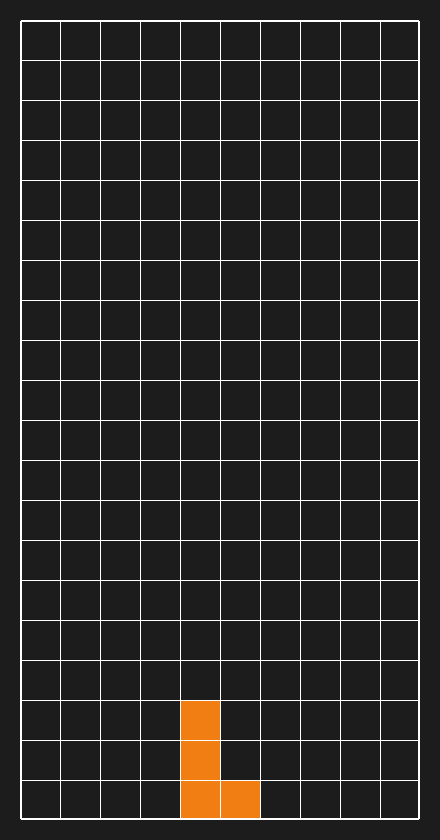

In [ ]:
from sys import exit

class Main:
  def __init__(self):

    # general
    pygame.init()
    self.display_surface = pygame.display.set_mode((WINDOW_WIDTH,WINDOW_HEIGHT))
    self.clock = pygame.time.Clock()

    # components
    self.game = Game()

  def run(self):
    while True:
      for event in pygame.event.get():
        if event.type == pygame.QUIT:
          pygame.quit()
          exit()

      # display
      self.display_surface.fill(GRAY)

      # components
      self.game.run()

      # updating the game
      pygame.display.update()
      self.clock.tick(60)

      # convert image so it can be displayed in OpenCV
      screen = pygame.surfarray.array3d(self.display_surface)

      # convert from (width, height, channel) to (height, width, channel)
      screen = screen.transpose([1, 0, 2])

      # convert from rgb to bgr
      canva = cv2.cvtColor(screen, cv2.COLOR_RGB2BGR)

      # display image, when happens a change
      cv2_imshow(canva)
      output.clear(wait=True)

if __name__ == '__main__':
  main = Main()
  main.run()